# RNN 모델의 작동 방식

## RNN

In [22]:
import torch
from torch import nn

# RNN 정의
rnn = nn.RNN(input_size=10, hidden_size=20, batch_first=True)

# 임의의 입력
x = torch.randn(1, 200, 10)  # 배치 크기: 1, 시퀀스 길이: 200, 입력 차원: 10
# t_1..t_200까지 순차적으로 10차원의 데이터가 들어가도록 만들겠다는 뜻.

# 모델 실행
output, hn = rnn(x)
# output은 모든 time 에서 나오는 모든 h들을 모아놓은 것
# hn은 200번에 해당하는 모든 데이터 포인트들을 다 지나간다음에 나오는 녀석

print(f"RNN output shape: {output.shape}")
print(f"RNN hn shape: {hn.shape}")


RNN output shape: torch.Size([1, 200, 20])
RNN hn shape: torch.Size([1, 1, 20])


## LSTM

In [23]:
# LSTM 정의
lstm = nn.LSTM(input_size=10, hidden_size=20, batch_first=True)

# 임의의 입력
x = torch.randn(1, 200, 10)  # 배치 크기: 1, 시퀀스 길이: 3, 입력 차원: 10
# t_1..t_200까지 순차적으로 10차원의 데이터가 들어가도록 만들겠다는 뜻.

# 모델 실행
output, (hn, cn) = lstm(x)
# 마찬가지로 output은 모든 time 에서 나오는 모든 h들을 모아놓은 것
# LSTM의 경우는 hidden state 에 더해서 channel state 도 있음에 유의

print(f"LSTM output shape: {output.shape}")
print(f"LSTM hn shape: {hn.shape}")
print(f"LSTM cn shape: {cn.shape}")


LSTM output shape: torch.Size([1, 200, 20])
LSTM hn shape: torch.Size([1, 1, 20])
LSTM cn shape: torch.Size([1, 1, 20])


## 일반적인 모델의 형태

In [24]:
class Model(nn.Module):
    def __init__(self, input_size, hid_size, output_size):
        super(Model, self).__init__()
        self.LSTM = nn.LSTM(input_size = input_size, hidden_size = hid_size, num_layers=2,
                            batch_first=True)
        self.fc1 = nn.Linear(self.hid_size, self.hid_size)
        self.fc2 = nn.Linear(self.hid_size, output_size)

    def forward(self, x):
        """
        input : [bs, maxlen]
        output: [bs, 2]
        """
        x, (h,c) = self.LSTM(x)  # [bs, ml, hid_size]
        x = F.relu(self.fc1(x[:,-1,:]))   # [bs, ml, hid_size]
        # x = F.relu(self.fc1(h))   # [bs, ml, hid_size]
        out = self.fc2(x)
        return out  # [bs, output_size]

# RNN모델을 통한 주가 예측 (regression)

In [25]:
!pip install yfinance scikit-learn matplotlib

In [26]:
train_x.shape

torch.Size([1855, 2000, 1])

In [50]:
import torch
import torch.nn as nn
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
data = yf.download('AAPL', '2000-01-01', '2023-07-01')
data = data['Close'].values

# 데이터 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# 설정값 정의
seq_length = 2000
pred_length = 200
hidden_dim = 50
n_features = 1

# 학습 데이터 생성
def create_sequences(data, seq_length, pred_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-pred_length):
        x = data[i:(i+seq_length)]
        y = data[(i+seq_length):(i+seq_length+pred_length)]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

x, y = create_sequences(data, seq_length, pred_length)
x = torch.tensor(x).float().view(-1, seq_length, n_features)
y = torch.tensor(y).float()

train_x = x[:len(x)//2]
test_x = x[len(x)//2:]
train_y = y[:len(y)//2]
test_y = y[len(y)//2:]

# 모델 정의
class StockPredictor(nn.Module):
    def __init__(self, n_features, hidden_dim, seq_length, pred_length):
        super(StockPredictor, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.pred_len = pred_length
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim*self.seq_len, out_features=pred_length)

    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        # use all of the hidden states for the linear layer
        x = lstm_out.contiguous().view(-1, self.hidden_dim*self.seq_len)
        y_pred = self.linear(x)
        return y_pred

model = StockPredictor(n_features, hidden_dim, seq_length, pred_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# make a data loader from torch
from torch.utils.data import DataLoader, TensorDataset

# batch sampling train loader
train_data = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

# training
model.train()
for epoch in range(5):  # 50번의 epoch 동안 학습
    model.train()
    # batch sampling
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        model.zero_grad()

        y_pred = model(train_x)
        loss = criterion(y_pred.float(), train_y)
        print("Epoch ", epoch, "MSE: ", loss.item())
        loss.backward()
        optimizer.step()

    # evaluate for each epoch
    model.eval()
    with torch.no_grad():
        y_pred = model(test_x)
        loss = criterion(y_pred.float(), test_y)
        print("Test Epoch ", epoch, "MSE: ", loss.item())



# 평가
model.eval()
test_preds = model(test_x)


[*********************100%%**********************]  1 of 1 completed
Epoch  0 MSE:  0.010472548194229603
Epoch  0 MSE:  27.530778884887695
Epoch  0 MSE:  1.6431307792663574
Epoch  0 MSE:  5.035581588745117
Epoch  0 MSE:  13.854544639587402
Epoch  0 MSE:  11.380188941955566
Epoch  0 MSE:  4.639267444610596
Epoch  0 MSE:  0.3706190586090088
Epoch  0 MSE:  0.7339215874671936
Epoch  0 MSE:  3.477562665939331
Epoch  0 MSE:  5.404728889465332
Epoch  0 MSE:  5.057440280914307
Epoch  0 MSE:  3.1536285877227783
Epoch  0 MSE:  1.129948616027832
Epoch  0 MSE:  0.09704949706792831
Epoch  0 MSE:  0.2007674276828766
Epoch  0 MSE:  1.044356107711792
Epoch  0 MSE:  1.8265914916992188
Epoch  0 MSE:  2.1248676776885986
Epoch  0 MSE:  1.7837072610855103
Epoch  0 MSE:  1.1234869956970215
Epoch  0 MSE:  0.4224444329738617
Epoch  0 MSE:  0.05235416814684868
Epoch  0 MSE:  0.06004144996404648
Epoch  0 MSE:  0.3328062891960144
Epoch  0 MSE:  0.6714120507240295
Epoch  0 MSE:  0.8511731028556824
Epoch  0 MSE:  

In [47]:
train_x.shape

torch.Size([31, 2000, 1])

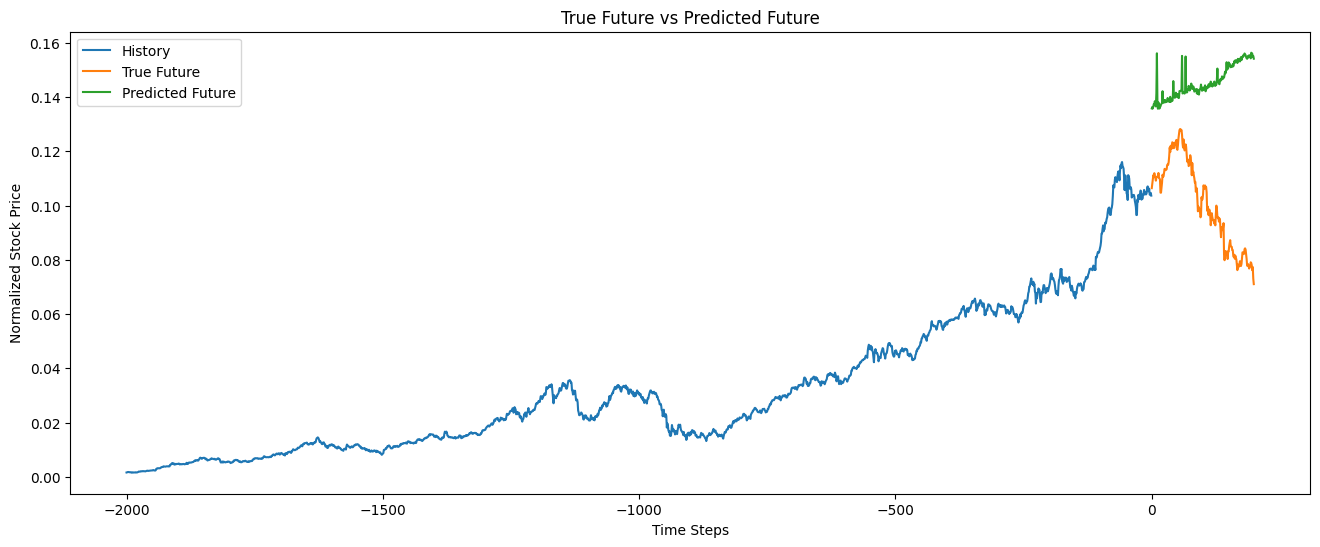

In [49]:
%matplotlib inline

plt.figure(figsize=(16,6))

range_future = len(test_y)
# plot from -2000 to 0
plt.plot(np.arange(-seq_length, 0, 1), train_x[0,:].numpy(), label='History')


plt.plot(np.arange(200), train_y[0,:].numpy(), label='True Future')
plt.plot(np.arange(200), y_pred[0,:].detach().numpy(), label='Predicted Future')

plt.title('True Future vs Predicted Future')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()


# RNN을 이용한 문서의 분류 (classification)

In [ ]:
!pip install tensorflow

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_WORDS)
x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding="post", truncating="post")
x_test = pad_sequences(x_test, maxlen=MAX_LEN, padding="post", truncating="post")
print(x_train.shape, x_test.shape)

In [ ]:
train_data = TensorDataset(torch.LongTensor(x_train), torch.LongTensor(y_train))
test_data = TensorDataset(torch.LongTensor(x_test), torch.LongTensor(y_test))

train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
class Model(nn.Module):
    def __init__(self, max_words, emb_size, hid_size):
        super(Model, self).__init__()
        self.max_words = max_words
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.Embedding = nn.Embedding(self.max_words, self.emb_size)
        self.LSTM = nn.LSTM(self.emb_size, self.hid_size, num_layers=2,
                            batch_first=True)
        self.fc1 = nn.Linear(self.hid_size, self.hid_size)
        self.fc2 = nn.Linear(self.hid_size, 2)

    def forward(self, x):
        """
        input : [bs, maxlen]
        output: [bs, 2]
        """
        x = self.Embedding(x)  # [bs, ml, emb_size]
        x, (h,c) = self.LSTM(x)  # [bs, ml, hid_size]
        x = F.relu(self.fc1(x[:,-1,:]))   # [bs, ml, hid_size]
        out = self.fc2(x)
        return out  # [bs, 2]

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        y_ = model(x)
        loss = criterion(y_, y)  # loss
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(x), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')
    test_loss = 0.0
    acc = 0
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            y_ = model(x)
        test_loss += criterion(y_, y)
        pred = y_.max(-1, keepdim=True)[1]
        acc += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, acc, len(test_loader.dataset),
        100. * acc / len(test_loader.dataset)))
    return acc / len(test_loader.dataset)

In [ ]:
MAX_WORDS = 10000  # imdb’s vocab_size
MAX_LEN = 200      # max length
BATCH_SIZE = 256
EMB_SIZE = 128   # embedding size
HID_SIZE = 128   # lstm hidden size


model = Model(MAX_WORDS, EMB_SIZE, HID_SIZE).to(DEVICE)
print(model)
optimizer = optim.Adam(model.parameters())

best_acc = 0.0
PATH = 'imdb model/model.pth'  #

for epoch in range(10):
    train(model, DEVICE, train_loader, optimizer, epoch)
    acc = test(model, DEVICE, test_loader)
    if best_acc < acc:
        best_acc = acc
        torch.save(model.state_dict(), PATH)
    print("acc is: {:.4f}, best acc is {:.4f}\n".format(acc, best_acc))